# House Prices: Advanced Regression Techniques

<p><a name="sections"></a></p>


## Sections

- <a href="#description">Description</a><br>
- <a href="#executive_summary">Executive Summary</a><br>
- <a href="#data_import">Data Import</a><br>
- <a href="#feature_engineering">Feature Engineering</a><br>
- <a href="#data_cleaning_and_eda">Data Cleaning and EDA</a><br>
- <a href="#models">Models</a><br>
    - <a href="#lasso">Lasso</a><br>
    - <a href="#decision_tree">Decision Tree</a><br>
    - <a href="#bagging">Bagging</a><br>
    - <a href="#random_forest">Random Forest</a><br>
    - <a href="#boosting">Boosting</a><br>
    - <a href="#xgboost">XGBoost</a><br>
- <a href="#submission">Submission</a><br>

<p><a name="description"></a></p>

## Description

<p><a name="executive_summary"></a></p>

## Executive Summary

<p><a name="data_import_and_cleaning"></a></p>

## Data Import and Cleaning

**import libaries**

In [1134]:
import numpy as np
import pandas as pd
from scipy.stats import skew
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV,RidgeCV,ElasticNetCV
from sklearn.model_selection import cross_val_score, train_test_split,GridSearchCV
from sklearn.model_selection import RepeatedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, make_scorer, mean_squared_log_error
from sklearn.preprocessing import StandardScaler
#import xgboost as xgb
#import lightgbm as lgb

**read data**

In [1135]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [1136]:
print('number of training samples: {}'.format(train.shape[0]))
train.head()

number of training samples: 1460


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [1137]:
print('number of testing samples: {}'.format(test.shape[0]))
test.head()

number of testing samples: 1459


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


**remove column id, target = log(1+Sales_Price)**

In [1138]:
# set column Id as index
train.drop(['Id'],axis=1,inplace=True)
test.drop(['Id'],axis=1,inplace=True)
# set log of SalePrice as target column
SalePrice = train['SalePrice']
# remove SalePrice from training data
train = train.iloc[:,:-1]
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


**observe that SalePrice is non-normal distribution with skeweness and kurtosis**

skewness: 1.8828757597682129
kurtosis: 6.536281860064529


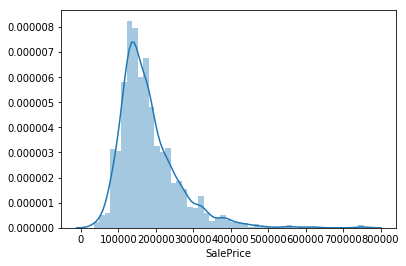

In [1139]:
sns.distplot(SalePrice);
#skewness and kurtosis
print('skewness: {}'.format(SalePrice.skew()))
print('kurtosis: {}'.format(SalePrice.kurt()))

**noramlize by log transformation log(1+p)**

skewness: 0.12134661989685333
kurtosis: 0.809519155707878


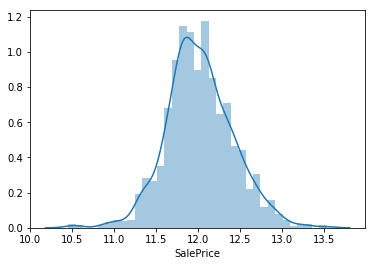

In [1140]:
target = np.log1p(SalePrice)
sns.distplot(target);
#skewness and kurtosis
print('skewness: {}'.format(target.skew()))
print('kurtosis: {}'.format(target.kurt()))

**remove outliers from train data:**
Two outliers with around 5,000 sq.ft. and $200,000 price

Text(0, 0.5, 'SalePrice')

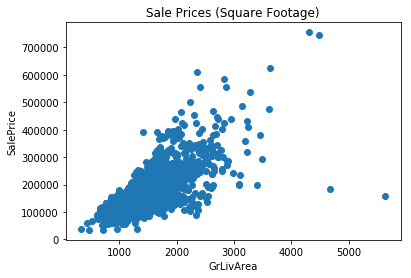

In [1141]:
plt.scatter(train['GrLivArea'], SalePrice, marker='o')
plt.title("Sale Prices (Square Footage)")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")

Text(0, 0.5, 'SalePrice')

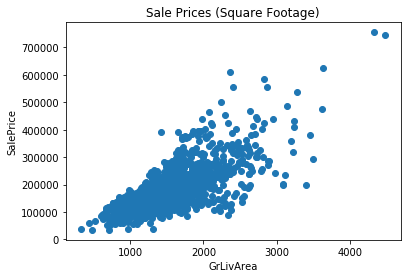

In [1142]:
mask = ~((SalePrice < 300000) & (train['GrLivArea']>4000))
train = train[mask]
SalePrice = SalePrice[mask]
target = target[mask]
train.reset_index(inplace=True, drop=True)
SalePrice.reset_index(inplace=True, drop=True)
target.reset_index(inplace=True, drop=True)
plt.scatter(train['GrLivArea'], SalePrice, marker='o')
plt.title("Sale Prices (Square Footage)")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")

**combine train and test data**

In [1143]:
data = pd.concat([train,test])
print('total number of training samples: {}'.format(train.shape[0]))
print('total number of samples: {}'.format(data.shape[0]))
data.reset_index(inplace=True)
data.head()

total number of training samples: 1458
total number of samples: 2917


,index,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


## Data Cleaning and EDA

**display percentage of NAs**

In [1144]:
temp = data.isnull().any()
cols_na = temp[temp==True].index.tolist()
data_na = data.loc[:,cols_na].isnull().astype(int).mean().sort_values(ascending=False)
data_na

PoolQC          0.996915
MiscFeature     0.964004
Alley           0.932122
Fence           0.804251
FireplaceQu     0.486802
LotFrontage     0.166610
GarageFinish    0.054508
GarageYrBlt     0.054508
GarageQual      0.054508
GarageCond      0.054508
GarageType      0.053822
BsmtExposure    0.028111
BsmtCond        0.028111
BsmtQual        0.027768
BsmtFinType2    0.027425
BsmtFinType1    0.027083
MasVnrType      0.008228
MasVnrArea      0.007885
MSZoning        0.001371
BsmtFullBath    0.000686
BsmtHalfBath    0.000686
Utilities       0.000686
Functional      0.000686
Exterior2nd     0.000343
Exterior1st     0.000343
SaleType        0.000343
BsmtFinSF1      0.000343
BsmtFinSF2      0.000343
BsmtUnfSF       0.000343
Electrical      0.000343
KitchenQual     0.000343
GarageCars      0.000343
GarageArea      0.000343
TotalBsmtSF     0.000343
dtype: float64

**substitute NAs in categoric variables as None**

In [1145]:
# Handle missing values for features where median/mean or most common value doesn't make sense
# some of the following are redundant

# Alley : data description says NA means "no alley access"
data['Alley'].fillna('None',inplace=True)

# BsmtQual etc : data description says NA for basement features is "no basement"
for col in ['BsmtFinType2','BsmtExposure','BsmtFinType1','BsmtCond','BsmtQual']:
    data[col].fillna('None',inplace=True)

# GarageType etc : data description says NA for garage features is "no garage"
for col in ['GarageType','GarageFinish','GarageQual','GarageCond']:
    data[col].fillna('None',inplace=True)
# GarageYrBlt: replace by mean
data['GarageYrBlt'].fillna(data['GarageYrBlt'].mean(),inplace=True)

for col in ['BsmtHalfBath','BsmtFullBath','Exterior1st','Exterior2nd','SaleType']:
    data[col].fillna(data[col].mode()[0],inplace=True)    
    
# replace by 0
for col in ['BsmtFinSF1','BsmtFinSF2','TotalBsmtSF','BsmtUnfSF','GarageCars','GarageArea']:
    data[col].fillna(0,inplace=True)    

# EnclosedPorch : NA most likely means no enclosed porch
data['EnclosedPorch'].fillna(0,inplace=True)  
# OpenPorchSF : NA most likely means no open porch
data['OpenPorchSF'].fillna(0,inplace=True)  
# ScreenPorch : NA most likely means no screen porch
data['ScreenPorch'].fillna(0,inplace=True) 
    
# PoolQC : data description says NA means "no pool"
data['PoolQC'].fillna('None',inplace=True)
data['PoolArea'].fillna(0,inplace=True)

# FireplaceQu : data description says NA means "no fireplace"
data['FireplaceQu'].fillna('None',inplace=True)
data['Fireplaces'].fillna(0,inplace=True)
        
# fill NA by median value in the neighborhood
data['LotFrontage'] = data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
# LotShape : NA most likely means regular
data['LotShape'].fillna('Reg',inplace=True)
    
# MasVnrType : NA most likely means no veneer
data['MasVnrType'].fillna('None',inplace=True)
data['MasVnrArea'].fillna(0,inplace=True)

# MiscFeature : data description says NA means "no misc feature"
data['MiscFeature'].fillna('None',inplace=True)
data['MiscVal'].fillna(0,inplace=True)

# KitchenAbvGr : NA most likely means 0
data['KitchenAbvGr'].fillna(0,inplace=True)
# KitchenQual : NA most likely means typical
data['KitchenQual'].fillna('TA',inplace=True)
    
# Utilities : NA most likely means all public utilities
data['Utilities'].fillna('AllPub',inplace=True)
# Electrical: NA most likely means SBrkr
data['Electrical'].fillna('Electrical',inplace=True)
        
# SaleCondition : NA most likely means normal sale
data['SaleCondition'].fillna('Normal',inplace=True)
# PavedDrive : NA most likely means not paved
data['PavedDrive'].fillna('N',inplace=True)
data['TotRmsAbvGrd'].fillna(0,inplace=True)
# NAs from test data
data['MSZoning'] = data.groupby('Neighborhood')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
# Fence : data description says NA means "no fence"
data['Fence'].fillna('None',inplace=True)
# Functional : data description says NA means typical
data['Functional'].fillna('Typ',inplace=True)
# HalfBath : NA most likely means no half baths above grade
data['HalfBath'].fillna(0,inplace=True)
# HeatingQC : NA most likely means typical
data['HeatingQC'].fillna('TA',inplace=True)

# Some numerical features are actually really categories
data = data.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

<p><a name="data_cleaning_and_eda"></a></p>

## Feature Engineering

In [1146]:
data['GrLivArea_log'] = np.log1p(data['GrLivArea'])
data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']
data['TotalSF_log'] = np.log1p(data['TotalSF'])
data['TotalBsmtSF'] = data['BsmtFinSF1'] + data['BsmtFinSF2'] + data['BsmtUnfSF']
data['TotalBsmtSF_log'] = np.log1p(data['BsmtFinSF1'] + data['BsmtFinSF2'] + data['BsmtUnfSF'])
data['OverallQual_log'] = np.log1p(data['OverallQual'])
data['YearBuilt_log'] = np.log1p(data['YearBuilt'])
data['OverallCond_log'] = np.log1p(data['OverallCond'])

**divide data into numeric and categoric variables**

In [1147]:
# numeric data
data_numeric = data._get_numeric_data()
# all columns
cols_all = data.columns.tolist()
# numeric columns
cols_numeric = data_numeric.columns.tolist()
# categoric columns
cols_categoric = list(set(cols_all)-set(cols_numeric))
# categoric data
data_categoric = data.loc[:,cols_categoric]
print('numeric columns: {}'.format(cols_numeric))
print('categoric columns: {}'.format(cols_categoric))

numeric columns: ['index', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold', 'GrLivArea_log', 'TotalSF', 'TotalSF_log', 'TotalBsmtSF_log', 'OverallQual_log', 'YearBuilt_log', 'OverallCond_log']
categoric columns: ['MSSubClass', 'CentralAir', 'PavedDrive', 'RoofMatl', 'SaleCondition', 'GarageFinish', 'BsmtQual', 'GarageType', 'Alley', 'MasVnrType', 'Fence', 'Electrical', 'LotConfig', 'BsmtFinType1', 'LandSlope', 'KitchenQual', 'ExterQual', 'Heating', 'Utilities', 'HeatingQC', 'Exterior2nd', 'MoSold', 'PoolQC', 'MSZoning', 'Foundation', 'Condition2', 'RoofStyle', 'Exter

**encode categoric features, drop duplicates**

In [1148]:
# encode categoric variables on entire data
data_categoric_encoded = pd.get_dummies(data_categoric)
# drop duplicates on train data along axis=1
train_categoric_encoded = data_categoric_encoded.iloc[:train.shape[0],:]
train_categoric_encoded = train_categoric_encoded.T.drop_duplicates().T
# find columns
cols = train_categoric_encoded.columns.tolist()
data_categoric_encoded = data_categoric_encoded.loc[:,cols]
data_categoric_encoded.head()

,MSSubClass_SC120,MSSubClass_SC150,MSSubClass_SC160,MSSubClass_SC180,MSSubClass_SC190,MSSubClass_SC20,MSSubClass_SC30,MSSubClass_SC40,MSSubClass_SC45,MSSubClass_SC50,...,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [1149]:
# combine numeric columns, encoded categoric columns, encoded NAs in numeric columns
data = pd.concat([data_categoric_encoded,data_numeric],axis=1)
cols = data.columns.tolist()
data.head()

,MSSubClass_SC120,MSSubClass_SC150,MSSubClass_SC160,MSSubClass_SC180,MSSubClass_SC190,MSSubClass_SC20,MSSubClass_SC30,MSSubClass_SC40,MSSubClass_SC45,MSSubClass_SC50,...,PoolArea,MiscVal,YrSold,GrLivArea_log,TotalSF,TotalSF_log,TotalBsmtSF_log,OverallQual_log,YearBuilt_log,OverallCond_log
0,0,0,0,0,0,0,0,0,0,0,...,0,0,2008,7.444833,2566.0,7.850493,6.753438,2.079442,7.602900,1.791759
1,0,0,0,0,0,1,0,0,0,0,...,0,0,2007,7.141245,2524.0,7.833996,7.141245,1.945910,7.589336,2.197225
2,0,0,0,0,0,0,0,0,0,0,...,0,0,2008,7.488294,2706.0,7.903596,6.825460,2.079442,7.601902,1.791759
3,0,0,0,0,0,0,0,0,0,0,...,0,0,2006,7.448916,2473.0,7.813592,6.629363,2.079442,7.557995,1.791759
4,0,0,0,0,0,0,0,0,0,0,...,0,0,2008,7.695758,3343.0,8.114923,7.044033,2.197225,7.601402,1.791759


**standardize all variables**

In [1150]:
data = (data - data.mean())/data.std()
data.head()

,MSSubClass_SC120,MSSubClass_SC150,MSSubClass_SC160,MSSubClass_SC180,MSSubClass_SC190,MSSubClass_SC20,MSSubClass_SC30,MSSubClass_SC40,MSSubClass_SC45,MSSubClass_SC50,...,PoolArea,MiscVal,YrSold,GrLivArea_log,TotalSF,TotalSF_log,TotalBsmtSF_log,OverallQual_log,YearBuilt_log,OverallCond_log
0,-0.257919,-0.018515,-0.214193,-0.076551,-0.146121,-0.766061,-0.223649,-0.045392,-0.078784,-0.330285,...,-0.060437,-0.089608,0.157422,0.570119,0.030059,0.179775,0.020083,0.685266,1.041414,-0.435542
1,-0.257919,-0.018515,-0.214193,-0.076551,-0.146121,1.304931,-0.223649,-0.045392,-0.078784,-0.330285,...,-0.060437,-0.089608,-0.602844,-0.369466,-0.023713,0.126781,0.348166,0.040221,0.162334,1.905216
2,-0.257919,-0.018515,-0.214193,-0.076551,-0.146121,-0.766061,-0.223649,-0.045392,-0.078784,-0.330285,...,-0.060437,-0.089608,0.157422,0.704626,0.209300,0.350363,0.081013,0.685266,0.976705,-0.435542
3,-0.257919,-0.018515,-0.214193,-0.076551,-0.146121,-0.766061,-0.223649,-0.045392,-0.078784,-0.330285,...,-0.060437,-0.089608,-1.363111,0.582755,-0.089008,0.061233,-0.084884,0.685266,-1.868765,-0.435542
4,-0.257919,-0.018515,-0.214193,-0.076551,-0.146121,-0.766061,-0.223649,-0.045392,-0.078784,-0.330285,...,-0.060437,-0.089608,0.157422,1.346715,1.024846,1.029225,0.265925,1.254237,0.944326,-0.435542


**select transformed traning set**

In [1151]:
X = data.iloc[:train.shape[0],:]
# save target in series y
y = target
print('number of training samples: {}'.format(X.shape[0]))
X.head()

number of training samples: 1458


,MSSubClass_SC120,MSSubClass_SC150,MSSubClass_SC160,MSSubClass_SC180,MSSubClass_SC190,MSSubClass_SC20,MSSubClass_SC30,MSSubClass_SC40,MSSubClass_SC45,MSSubClass_SC50,...,PoolArea,MiscVal,YrSold,GrLivArea_log,TotalSF,TotalSF_log,TotalBsmtSF_log,OverallQual_log,YearBuilt_log,OverallCond_log
0,-0.257919,-0.018515,-0.214193,-0.076551,-0.146121,-0.766061,-0.223649,-0.045392,-0.078784,-0.330285,...,-0.060437,-0.089608,0.157422,0.570119,0.030059,0.179775,0.020083,0.685266,1.041414,-0.435542
1,-0.257919,-0.018515,-0.214193,-0.076551,-0.146121,1.304931,-0.223649,-0.045392,-0.078784,-0.330285,...,-0.060437,-0.089608,-0.602844,-0.369466,-0.023713,0.126781,0.348166,0.040221,0.162334,1.905216
2,-0.257919,-0.018515,-0.214193,-0.076551,-0.146121,-0.766061,-0.223649,-0.045392,-0.078784,-0.330285,...,-0.060437,-0.089608,0.157422,0.704626,0.209300,0.350363,0.081013,0.685266,0.976705,-0.435542
3,-0.257919,-0.018515,-0.214193,-0.076551,-0.146121,-0.766061,-0.223649,-0.045392,-0.078784,-0.330285,...,-0.060437,-0.089608,-1.363111,0.582755,-0.089008,0.061233,-0.084884,0.685266,-1.868765,-0.435542
4,-0.257919,-0.018515,-0.214193,-0.076551,-0.146121,-0.766061,-0.223649,-0.045392,-0.078784,-0.330285,...,-0.060437,-0.089608,0.157422,1.346715,1.024846,1.029225,0.265925,1.254237,0.944326,-0.435542


<p><a name="models"></a></p>   

## Models 

**repeated k-fold cross-validation - input parameter to models**

In [1152]:
# repeatedkfold = RepeatedKFold()
rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=2652124)

**define models**

In [1153]:
# lasso model
lassocv = LassoCV(cv=rkf,n_alphas=100)
# ridge model
ridgecv = RidgeCV(cv=rkf)
# elastic net
elasticnetcv = ElasticNetCV(cv=rkf,n_alphas=100)
# random forest
rf = RandomForestRegressor(random_state = 42)
# kernel ridge
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
# gradient boosting
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
"""
# XG boost
xgboost = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
# 
lightgboost = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
"""

"\n# XG boost\nxgboost = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, \n                             learning_rate=0.05, max_depth=3, \n                             min_child_weight=1.7817, n_estimators=2200,\n                             reg_alpha=0.4640, reg_lambda=0.8571,\n                             subsample=0.5213, silent=1,\n                             random_state =7, nthread = -1)\n# \nlightgboost = lgb.LGBMRegressor(objective='regression',num_leaves=5,\n                              learning_rate=0.05, n_estimators=720,\n                              max_bin = 55, bagging_fraction = 0.8,\n                              bagging_freq = 5, feature_fraction = 0.2319,\n                              feature_fraction_seed=9, bagging_seed=9,\n                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)\n"

<p><a name="lasso"></a></p>

## Models: Lasso

In [1154]:
reg = lassocv.fit(X,y)

No handles with labels found to put in legend.


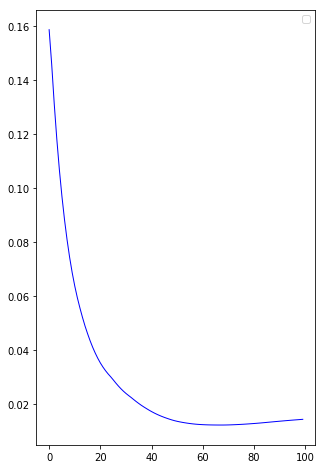

In [1155]:
mse_path = np.mean(reg.mse_path_,axis=1)
fig = plt.figure(figsize=(5,8))
plt.plot(mse_path,color='blue',linewidth=1)
plt.legend()
plt.show()

In [1156]:
reg.score(X,y)

0.9426206426265794

In [1157]:
coefs = pd.Series(reg.coef_.tolist(),index=cols)
coefs = coefs[coefs!=0]
print('numer of coefficients: {}'.format(len(coefs)))
coefs = coefs.sort_values(ascending=False)

numer of coefficients: 130


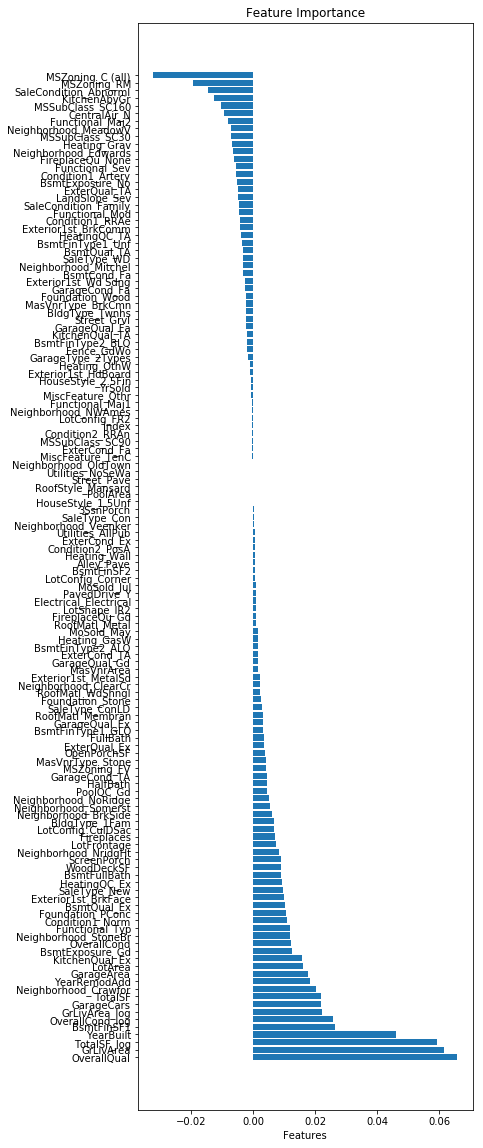

In [1158]:
objects = coefs.index.tolist()
y_arange = np.arange(len(objects))
values = coefs.tolist()
fig = plt.figure(figsize=(6,20))
plt.barh(y_arange, values, align='center')
plt.yticks(y_arange, objects)
plt.xlabel('Features')
plt.title('Feature Importance')
plt.show()

In [1159]:
# intercept is an average of sale prices
reg.intercept_

12.0173733005724

**estimate sale prices**

In [1160]:
y_estimated = lassocv.predict(X)
df_y = pd.DataFrame({'y':y,'y_estimated':y_estimated}).sort_values('y')
df_y.head()

,y,y_estimated
495,10.460271,10.876812
915,10.471978,10.684366
967,10.542733,11.073630
532,10.579005,10.739071
30,10.596660,11.131893


**plot actual and estimated sale prices**

No handles with labels found to put in legend.


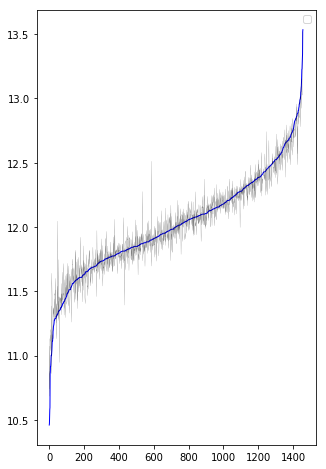

In [1161]:
fig = plt.figure(figsize=(5,8))
plt.plot(df_y['y'].tolist(),color='blue',linewidth=1)
plt.plot(df_y['y_estimated'].tolist(),color='black',linewidth=0.1)
plt.legend()
plt.show()

**lasso testing rate with 10-fold cross-validation**

In [1119]:
repeatedkfold = RepeatedKFold()
rkf = RepeatedKFold(n_splits=10, n_repeats=1, random_state=2652124)
sample = range(0,X.shape[0])
train_score = []
test_score = []
y_train_lst = []
y_train_estimated_lst = []
y_test_lst = []
y_test_estimated_lst = []
iteration = 1
for train_index, test_index in rkf.split(sample):
    print('iteration {}'.format(iteration))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    reg = lassocv.fit(X_train,y_train)
    train_score.append(reg.score(X_train,y_train))
    test_score.append(reg.score(X_test,y_test))
    y_train_lst += y_train.tolist()
    y_test_lst += y_test.tolist()
    y_train_estimated_lst += lassocv.predict(X_train).tolist()
    y_test_estimated_lst += lassocv.predict(X_test).tolist()
    iteration += 1
print('train_score={}'.format(train_score))
print('test_score={}'.format(test_score))

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
train_score=[0.9425338870461644, 0.9461761452521933, 0.9430465929731544, 0.946310700709919, 0.9430066396291747, 0.9404225746382527, 0.9399186564680221, 0.9457188175205913, 0.9429796507710273, 0.9354543281589576]
test_score=[0.9127027332122699, 0.8932542071315979, 0.9168506233000935, 0.898927049883859, 0.9292153605318304, 0.9287372107797343, 0.9441770525646666, 0.9268702984535776, 0.9040188459746733, 0.956521680110833]


In [1133]:
print('mean train_score: {}'.format(np.mean(np.array(train_score))))
print('std train_score: {}'.format(np.std(np.array(train_score))))
print('mean test_score: {}'.format(np.mean(np.array(test_score))))
print('std test_score: {}'.format(np.std(np.array(test_score))))
print('train root_mean_squared_log_error: {}'.\
      format(np.sqrt(mean_squared_log_error(np.exp(y_train_lst),np.exp(y_train_estimated_lst)))))
print('test root_mean_squared_log_error: {}'.\
      format(np.sqrt(mean_squared_log_error(np.exp(y_test_lst),np.exp(y_test_estimated_lst)))))

mean train_score: 0.9425567993167456
std train_score: 0.0031586578077469536
mean test_score: 0.9211275061943137
std test_score: 0.01895279829560834
train root_mean_squared_log_error: 0.09573735743231661
test root_mean_squared_log_error: 0.11132219034534915


<p><a name="submission"></a></p>

## Submission

In [1087]:
submission = pd.read_csv("sample_submission.csv")
# test data
X = data.iloc[train.shape[0]:,:]
y = submission['SalePrice']
y_estimated = np.exp(lassocv.predict(X))-1
df = pd.DataFrame({'y':y,'y_estimated':y_estimated})
submission['SalePrice'] = y_estimated
submission.to_csv("submission.csv", index=False)